In [2]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering

┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1192


In [47]:
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools

In [5]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [6]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

In [7]:
masamax=maximum(fruncio[:,3])

10774.7926902771

In [8]:
nmax=maximum(fruncio[:,4])

1266.0

In [9]:
xx=fruncio[:,1]
yy=fruncio[:,2]
gordis=fruncio[:,3]
nn=fruncio[:,4];

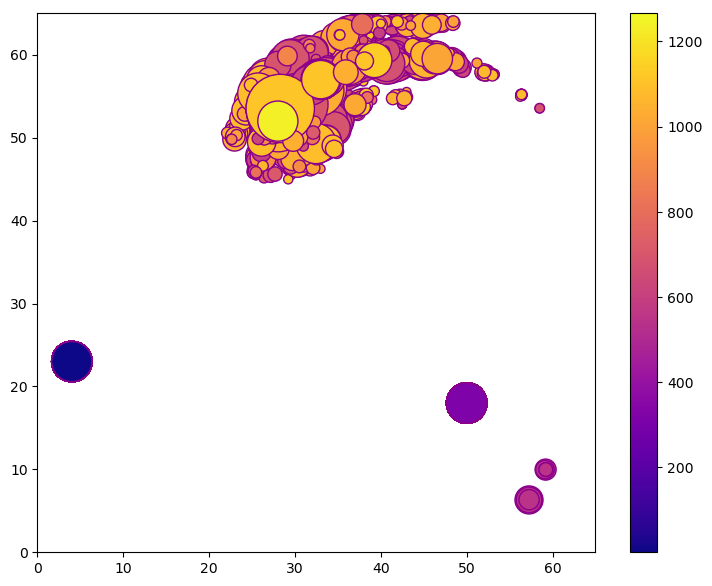

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0a978d7748>

In [10]:
figure(figsize=(9,7))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(xx,yy, s=0.25*gordis, edgecolors="darkmagenta", c=nn, cmap="plasma")
colorbar()

In [11]:
# clust1=fruncio[:,1:2];
clust1=permutedims(fruncio)

4×1947 Array{Float64,2}:
   49.9978    42.5091    35.1841  …    45.9395    28.0012    49.9984
   18.0004    60.5105    61.9064       63.5988    51.9968    17.9983
 3355.89     168.736    931.898       725.369   3339.65    3345.59  
  306.0     1131.0     1131.0        1042.0     1241.0      322.0   

In [12]:
function normalizar1(xx::Array)
    norma=maximum(abs.(xx))
    result=xx./norma
    return result
end

normalizar1 (generic function with 1 method)

In [13]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64

1947-element Array{Float64,1}:
 15.469194312796208
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
  3.740916271721959
 63.94944707740916 
 14.407582938388625
 14.407582938388625
 16.075829383886255
 56.821484992101105
  ⋮                
 57.6303317535545  
 57.6303317535545  
 17.238546603475513
 16.22748815165877 
 56.11374407582938 
 56.11374407582938 
 56.11374407582938 
 52.67614533965245 
 52.67614533965245 
 52.67614533965245 
 62.73617693522907 
 16.278041074249604

In [16]:
using Distances

In [17]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×1947 Array{Float64,2}:
 49.9978  42.5091  35.1841  32.9889  …  35.9196  45.9395  28.0012  49.9984
 18.0004  60.5105  61.9064  57.0028     57.8932  63.5988  51.9968  17.9983
 15.4692  57.1754  57.1754  57.1754     52.6761  52.6761  62.7362  16.278 

In [18]:
dd4d=pairwise(Euclidean(), clust1);

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = ip:0x0
└ @ Core :-1


In [19]:
dd3d=pairwise(Euclidean(), clustspaciotiempo);
dd2d=pairwise(Euclidean(), clust1[1:2,:]);

In [20]:
clust1[4,:]

1947-element Array{Float64,1}:
 15.469194312796208
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
 57.175355450236964
  3.740916271721959
 63.94944707740916 
 14.407582938388625
 14.407582938388625
 16.075829383886255
 56.821484992101105
  ⋮                
 57.6303317535545  
 57.6303317535545  
 17.238546603475513
 16.22748815165877 
 56.11374407582938 
 56.11374407582938 
 56.11374407582938 
 52.67614533965245 
 52.67614533965245 
 52.67614533965245 
 62.73617693522907 
 16.278041074249604

In [21]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

Hclust{Float64}([-394 -692; -669 -1426; … ; 784 1943; 1944 1945], [9.36836e-6, 1.08421e-5, 2.18722e-5, 2.27687e-5, 2.388e-5, 2.3899e-5, 2.90832e-5, 3.26346e-5, 3.26485e-5, 3.27737e-5  …  1.33258, 1.33742, 1.83203, 2.35494, 2.66311, 3.95368, 4.01235, 12.1322, 31.0744, 32.9743], [93, 411, 1237, 565, 1672, 389, 460, 740, 1611, 1553  …  634, 893, 282, 1388, 1646, 1858, 552, 1433, 1015, 1196], :single)

In [107]:
nivel=1000
hcorta=0.99
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [108]:
unique(clust2d)

22-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22

### 

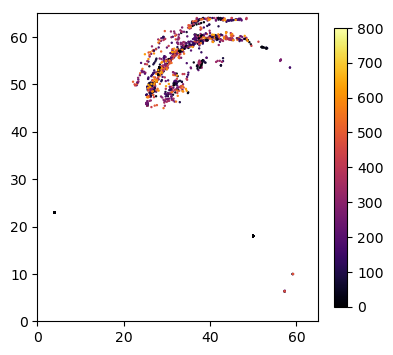

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0a9147e080>

In [109]:
fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(xx,yy, s=0.5, c=clust4d, cmap="inferno", vmin=0, vmax=800)
colorbar(fraction=0.045)

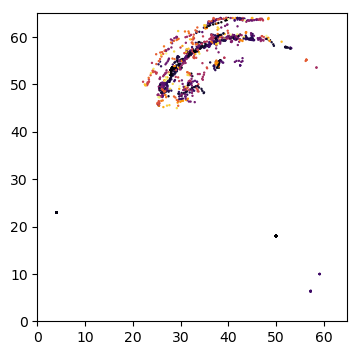

PyObject <matplotlib.collections.PathCollection object at 0x7f0a913e2fd0>

In [110]:
fafa=figure(figsize=(4,4))
#axis("equal")
#ax = fafa.add_subplot(111, projection="3d")
xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(xx,yy, s=0.5, c=clust3d, cmap="inferno")
#colorbar(fraction=0.045)

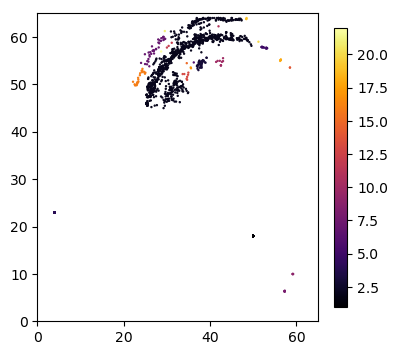

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0a91373208>

In [111]:
fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(xx,yy, s=0.5, c=clust2d, cmap="inferno")
colorbar(fraction=0.045)

In [112]:
function filtraclusterchicos(puntos::Array, clustree, umbral)
    tabla=hcat(puntos,clustree)
    valores=unique(clustree)
    dd=Dict([(i,count(x->x==i,clustree)) for i in valores])
    predicado(j)=dd[j]>umbral
    result=tabla[map(x->predicado(x), clustree),:]
    (clusterfuck, cual)=findmax(dd)
    println("el cluster mayor tiene ",clusterfuck, " elementos, es el ", cual)
    return result
end

function filtraclusterchicos(puntos::Dict, umbral)
   result=Dict{Int, Set}()
    for k in keys(puntos)
        if length(puntos[k])>umbral
            result[k]=puntos[k]
        end
    end
    return result
end


filtraclusterchicos (generic function with 3 methods)

In [113]:
function declustaset(puntosyclust::Array)
    result=Dict{Int,Set}()
    clustnames=unique(puntosyclust[:,5])
    for q in clustnames
        subt=puntosyclust[puntosyclust[:,5].==q,:]
        punt=rowstoset(round.(Int64,subt[:,1:2]))
        qindez=round(Int64,q)
        result[qindez]=punt
    end
    return result
end

declustaset (generic function with 1 method)

In [114]:
temp=hcat(fruncio, clust2d)
dict2d=declustaset(temp)
blabla=filtraclusterchicos(dict2d, 4)

Dict{Int64,Set} with 5 entries:
  7  => Set(Array{Int64,2}[[26 55], [26 56], [29 60], [24 55], [27 58], [29 59]…
  10 => Set(Array{Int64,2}[[43 54], [42 54], [43 56], [42 55], [43 55], [41 55]…
  2  => Set(Array{Int64,2}[[42 61], [31 56], [38 60], [28 53], [32 49], [35 60]…
  3  => Set(Array{Int64,2}[[38 55], [39 56], [37 53], [37 55], [37 54], [38 54]…
  16 => Set(Array{Int64,2}[[23 50], [22 51], [25 52], [24 52], [23 51], [24 53]…

In [115]:
#funcion solo para plotear, no se si luego la vas a usar.
function dictatabla(dict::Dict)
    aux=[0 0 0]
    for q in keys(dict)
        aux2=[0 0]
        for renglon in dict[q]
            aux2=vcat(aux2, renglon)
        end
        (l,k)=size(aux2)
        columnaextra=ones(Int64, l).*q
        aux3=hcat(aux2, columnaextra)
        aux=vcat(aux, aux3)
    end
    return aux[2:end,:]
end

dictatabla (generic function with 1 method)

In [116]:
blatabla=dictatabla(blabla)

209×3 Array{Int64,2}:
  0   0   7
 26  55   7
 26  56   7
 29  60   7
 24  55   7
 27  58   7
 29  59   7
 25  54   7
 26  57   7
 28  59   7
 30  60   7
 28  58   7
 26  54   7
  ⋮        
 37  54   3
 38  54   3
 39  55   3
 38  53   3
  0   0  16
 23  50  16
 22  51  16
 25  52  16
 24  52  16
 23  51  16
 24  53  16
 25  53  16

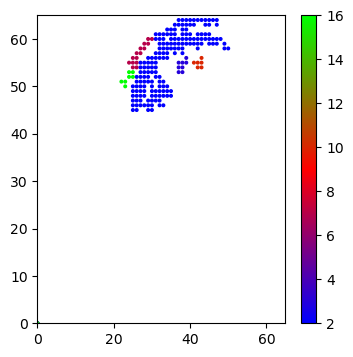

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0a91285240>

In [117]:
fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(blatabla[:,1], blatabla[:,2], c=blatabla[:,3], s=3.5, cmap="brg")
colorbar()

In [49]:
blabla

862×5 Array{Float64,2}:
 49.9978   18.0004  3355.89    306.0   1.0
 32.9889   57.0028  3381.34   1131.0   4.0
 28.2295   53.5208  9503.86   1131.0   5.0
  4.00008  23.0012  3360.28     74.0   8.0
  4.00163  22.9998  3360.78    285.0   8.0
 50.0004   17.9993  3361.53    285.0   1.0
 49.9989   18.001   3347.37    318.0   1.0
 33.0011   56.9897  3272.08   1124.0   4.0
 28.2427   53.5222  9391.15   1124.0   5.0
 49.9981   18.0009  3357.88    354.0   1.0
 37.6388   59.9197   487.17   1082.0  17.0
  4.00311  22.9998  3359.37    117.0   8.0
 49.9992   17.9989  3363.02    474.0   1.0
  ⋮                                       
 50.0012   18.0008  3359.09    381.0   1.0
  3.99833  22.9997  3356.67      3.0   8.0
 33.0168   56.9988  3299.85   1140.0   4.0
 28.2317   53.5041  9437.25   1140.0   5.0
 50.0019   17.9975  3366.41    341.0   1.0
 49.9991   17.999   3341.66    321.0   1.0
 28.2798   53.5162  9687.06   1110.0   5.0
 33.0002   57.0007  3043.45   1110.0   4.0
 38.093    59.2485   673.222  

In [85]:
decl=declustaset(blabla)

Dict{Int64,Set} with 17 entries:
  2  => Set(Array{Int64,2}[[42 61], [30 53], [31 56], [29 53], [30 56], [40 59]…
  11 => Set(Array{Int64,2}[[49 59], [48 60]])
  10 => Set(Array{Int64,2}[[52 58], [53 58]])
  35 => Set(Array{Int64,2}[[27 53], [27 52], [26 52], [28 52]])
  55 => Set(Array{Int64,2}[[23 50], [23 51]])
  66 => Set(Array{Int64,2}[[29 46], [29 47], [30 47], [30 46], [31 47]])
  8  => Set(Array{Int64,2}[[31 53], [31 52], [32 52]])
  22 => Set(Array{Int64,2}[[25 45], [26 46], [25 46]])
  6  => Set(Array{Int64,2}[[4 23]])
  51 => Set(Array{Int64,2}[[25 52], [24 52], [24 53], [25 53]])
  4  => Set(Array{Int64,2}[[32 50], [30 47], [32 49], [30 48], [31 49], [33 49]…
  3  => Set(Array{Int64,2}[[37 63], [39 63], [35 62], [40 64], [36 63], [38 64]…
  5  => Set(Array{Int64,2}[[38 55], [37 53], [37 55], [37 54], [38 54], [39 55]…
  14 => Set(Array{Int64,2}[[45 61], [45 59], [43 60], [45 60], [44 60]])
  27 => Set(Array{Int64,2}[[47 60], [47 59], [46 59], [46 60]])
  15 => Set(Array{Int

In [87]:
decl[2]

Set(Array{Int64,2}[[42 61], [30 53], [31 56], [29 53], [30 56], [40 59], [38 60], [28 53], [39 60], [28 54]  …  [26 49], [42 60], [36 61], [34 59], [28 49], [37 60], [27 49], [27 50], [41 59], [27 51], [28 48]])

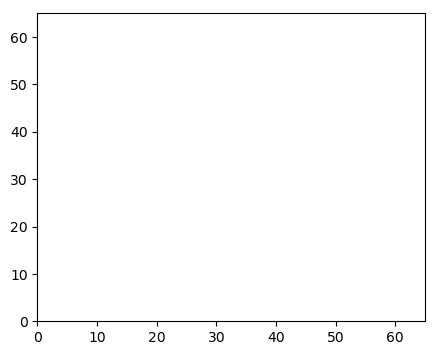

2 cubre 68electrodos. 
11 cubre 2electrodos. 
10 cubre 2electrodos. 
35 cubre 4electrodos. 
55 cubre 2electrodos. 
66 cubre 5electrodos. 
8 cubre 3electrodos. 
22 cubre 3electrodos. 
6 cubre 1electrodos. 
51 cubre 4electrodos. 
4 cubre 16electrodos. 
3 cubre 10electrodos. 
5 cubre 7electrodos. 
14 cubre 5electrodos. 
27 cubre 4electrodos. 
15 cubre 11electrodos. 
1 cubre 1electrodos. 


In [93]:
fafa=figure(figsize=(5,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
for q in keys(decl)
 print(q, " cubre ", length(decl[q]), "electrodos. \n")
end
#colorbar()

In [90]:
pum=[0 0]
for q in decl[2]
    pum=vcat(pum, q)
end

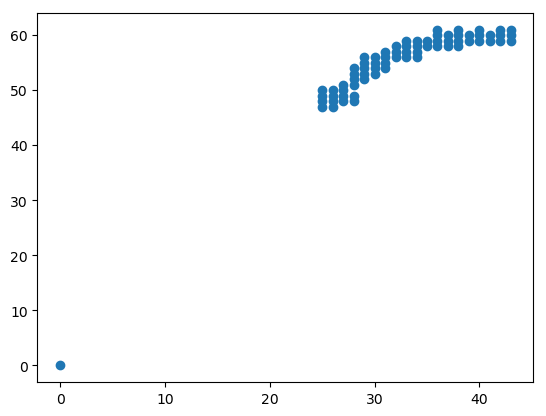

PyObject <matplotlib.collections.PathCollection object at 0x7f0a915dca20>

In [91]:
scatter(pum[:,1], pum[:,2])